150/150 [==============================] - 0s 882us/step - loss: 1.4303 - accuracy: 0.4896
final test accuracy: 0.48955780267715454
4795/4795 [==============================] - 2s 452us/step


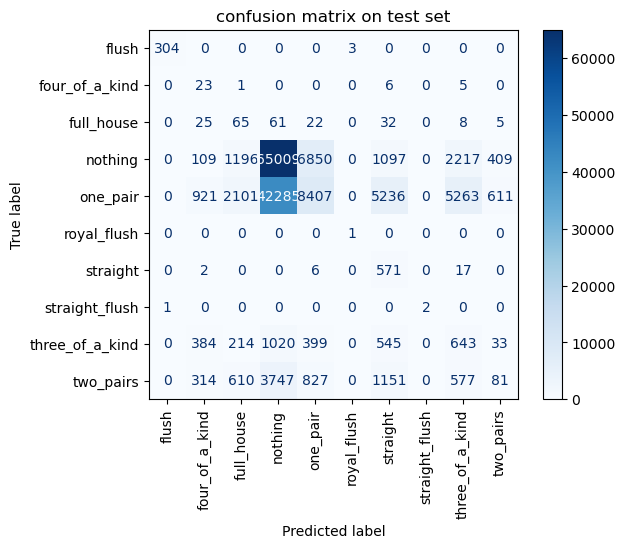

In [4]:
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# load metadata and best model
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)
model = keras.models.load_model('../artifacts/best_so_far.keras')

# load test data and scale it
X_test = np.load('../artifacts/X_test.npy')
y_test = np.load('../artifacts/y_test.npy')
X_mean = np.load('../artifacts/X_mean.npy')
X_std  = np.load('../artifacts/X_std.npy')
X_test_s = (X_test - X_mean) / X_std

# one hot
num_classes = len(meta['label_classes'])
y_test_oh = keras.utils.to_categorical(y_test, num_classes)

# evaluate
loss, acc = model.evaluate(X_test_s, y_test_oh, batch_size=1024)
print('final test accuracy:', acc)

y_pred = model.predict(X_test_s).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=meta['label_classes'])
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title('confusion matrix on test set')
plt.savefig('../artifacts/test_confusion_matrix.png', dpi=150)
